### 키워드로 검색할 경우

1. 키워드가 속한 클러스터를 찾기
    - embbeder(SentenceTransformer) -> umap reducer -> hdbscan_cluster
    - result : 클러스터 number -> 만약 -1일 경우 어떻게 해야할지 고민
2. 해당 키워드와 비슷한 조항을 찾기
    - 입력 키워드 : Source Sentence
    - 결과 클러스터의 조항들 : compare sentence

In [1]:
import pandas as pd
emb_df = pd.read_csv("./embded_result.csv", encoding="utf-8", index_col=0)
cluster_df = pd.read_csv("./keywords_with_cluster.csv", encoding="utf-8")

#### 1. 키워드 속한 클러스터 찾기

In [2]:
from tqdm.autonotebook import tqdm, trange
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\sstkb\AppData\Local\Temp\ipykernel_296\424947652.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# 1. embedder

embedder = SentenceTransformer('paraphrase-distilroberta-base-v1')

c:\Users\sstkb\anaconda3\envs\ds_study\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# 2. reducer
filename = "./umap_reducer.sav"
loaded_reducer = joblib.load(filename)

In [5]:
# 3. cluster model
filename = "./cluster_model.sav"
loaded_cluster_model = joblib.load(filename)

In [6]:
# 4. keywords 관련 클래스

class keywords_pipeline:
    # 생성자
    def __init__(self, embedder=embedder, reducer=loaded_reducer,
                 cluster_model=loaded_cluster_model, cluster_df=cluster_df, emb_df=emb_df):
        self.embedder = embedder
        self.reducer = reducer
        self.cluster_model = cluster_model
        self.cluster_df = cluster_df
        self.emb_df = emb_df

        self.tmp_corpus_emb = []
        self.tmp_same_cluster_statutes = []
        self.tmp_cluster = []
        self.tmp_strength = []

    # class 정보 가져오기
    def get_embedder(self):
        return self.embedder
    def get_reducer(self):
        return self.reducer
    def get_cluster_model(self):
        return self.cluster_model
    def get_cluster_df(self):
        return self.cluster_df
    def get_emb_df(self):
        return self.emb_df

    # Sentence Embedding
    # -> 최종 결과 도출 시에도 사용할 것이라 저장해두기
    def corpus_embedding(self, corpus):
        corpus_lst = list(corpus)
        self.tmp_corpus_emb = self.embedder.encode(corpus_lst)

    # Embedding된 corpus return
    def get_corpus_emb(self):
        return self.tmp_corpus_emb

    # cluster 도출 함수
    def find_cluster_(self, corpus):
        self.corpus_embedding(corpus)
        reduction_result = self.reducer.transform(self.tmp_corpus_emb)
        cluster, strength = hdbscan.approximate_predict(self.cluster_model, reduction_result)
        self.tmp_cluster = cluster
        self.tmp_strength = strength
        return cluster
    
    # predict : 결과에 해당되는 법령만 가져오기 
    def predict(self, corpus):
        self.find_cluster_(corpus)
        if len(self.tmp_cluster)==1:
            tmp = self.cluster_df[self.cluster_df["cluster"]==self.tmp_cluster[0]]
            tmp = pd.merge(tmp, self.emb_df, how="left", on=["법령일련번호", "Contents"])
            self.tmp_same_cluster_statutes = tmp
            return tmp
        else:
            tmp_lst = []
            for c in self.tmp_cluster:
                tmp = self.cluster_df[self.cluster_df["cluster"]==c]
                tmp_lst.append(pd.merge(tmp, self.emb_df, how="left", on=["법령일련번호", "Contents"]))
            self.tmp_same_cluster_statutes = tmp_lst
            return tmp_lst

In [68]:
# 5. 테스트
extract_statute = keywords_pipeline(embedder=embedder, reducer=loaded_reducer, cluster_model=loaded_cluster_model,
                  cluster_df=cluster_df, emb_df=emb_df)

In [69]:
tmp = extract_statute.predict(["medical services for foreigners"])

In [49]:
tmp[["cluster", "법령명한글"]].sample(10)

,cluster,법령명한글
87535,35,한국국제보건의료재단법
62092,35,의료법 시행령
62081,35,의료법 시행령
8524,35,공중보건장학을 위한 특례법
62399,35,의료 해외진출 및 외국인환자 유치 지원에 관한 법률
1614,35,감염병의 예방 및 관리에 관한 법률
93254,35,호스피스ㆍ완화의료 및 임종과정에 있는 환자의 연명의료결정에 관한 법률
61865,35,의료기사 등에 관한 법률
44663,35,생명윤리 및 안전에 관한 법률 시행규칙
71800,35,정신건강증진 및 정신질환자 복지서비스 지원에 관한 법률


In [30]:
tmp = extract_statute.predict(["lease loan and find house"])

In [32]:
tmp[["cluster", "법령명한글"]].sample(10)

,cluster,법령명한글
30697,80,민법
42227,80,상가건물 임대차보호법
95342,80,회사정리법
6820,80,공공토지의 비축에 관한 법률
15029,80,국유재산법
83524,80,친일반민족행위자 재산의 국가귀속에 관한 특별법
13795,80,국민연금법 시행령
37256,80,부동산 가격공시에 관한 법률
41225,80,산업입지 및 개발에 관한 법률
29858,80,민간임대주택에 관한 특별법


In [82]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Columns: 777 entries, 법령일련번호 to 767
dtypes: float64(768), int64(2), object(7)
memory usage: 1.4+ MB


#### 2. 클러스터 내에서 키워드와 가장 비슷한 조항 찾기

In [10]:
from sentence_transformers import SentenceTransformer, SimilarityFunction

sim_model = SentenceTransformer('paraphrase-distilroberta-base-v1', similarity_fn_name=SimilarityFunction.COSINE)

c:\Users\sstkb\anaconda3\envs\ds_study\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
class keywords_pipeline:
    # 생성자
    def __init__(self, embedder=embedder, reducer=loaded_reducer,
                 cluster_model=loaded_cluster_model, cluster_df=cluster_df, emb_df=emb_df):
        self.embedder = embedder
        self.reducer = reducer
        self.cluster_model = cluster_model
        self.cluster_df = cluster_df
        self.emb_df = emb_df

        self.__tmp_corpus = []
        self.__tmp_corpus_emb = []
        self.__tmp_same_cluster_statutes = []
        self.__tmp_cluster = []
        self.__tmp_strength = []

    # 임시 정보 get 함수들
    def get_corpus(self):
        return self.__tmp_corpus
    def get_corpus_emb(self):
        return self.__tmp_corpus_emb
    def get_same_cluster_statutes(self):
        return self.__tmp_same_cluster_statutes
    def get_cluster(self):
        return self.__tmp_cluster
    def get_strength(self):
        return self.__tmp_strength
    

    # Sentence Embedding
    # -> 최종 결과 도출 시에도 사용할 것이라 저장해두기
    def corpus_embedding(self, corpus):
        if isinstance(corpus, list):
            corpus_lst = corpus
        else:
            corpus_lst = [corpus]
        self.__tmp_corpus = corpus_lst
        self.__tmp_corpus_emb = self.embedder.encode(corpus_lst)

    # cluster 도출 함수
    def find_cluster_(self, corpus):
        self.corpus_embedding(corpus)
        reduction_result = self.reducer.transform(self.__tmp_corpus_emb)
        cluster, strength = hdbscan.approximate_predict(self.cluster_model, reduction_result)
        self.__tmp_cluster = cluster
        self.__tmp_strength = strength
        return cluster
    
    # predict : 결과에 해당되는 법령만 가져오기 
    def predict(self, corpus):
        self.find_cluster_(corpus)
        if len(self.__tmp_cluster)==1:
            tmp = self.cluster_df[self.cluster_df["cluster"]==self.__tmp_cluster[0]]
            tmp = pd.merge(tmp, self.emb_df, how="left", on=["법령일련번호", "Contents"])
            self.__tmp_same_cluster_statutes = tmp
            return tmp
        else:
            tmp_lst = []
            for c in self.__tmp_cluster:
                tmp = self.cluster_df[self.cluster_df["cluster"]==c]
                tmp_lst.append(pd.merge(tmp, self.emb_df, how="left", on=["법령일련번호", "Contents"]))
            self.__tmp_same_cluster_statutes = tmp_lst
            return tmp_lst

In [65]:
class keywords_article(keywords_pipeline):
    def __init__(self, simFunc="cosine", embedder=embedder, reducer=loaded_reducer,
                 cluster_model=loaded_cluster_model, cluster_df=cluster_df, emb_df=emb_df):
        
        super().__init__(embedder, reducer, cluster_model, cluster_df, emb_df)

        self.sim_model = embedder
        # similarity 적용 함수 선언
        if simFunc=="cosine":
            self.sim_model.similarity_fn_name = SimilarityFunction.COSINE
        elif simFunc=="dot":
            self.sim_model.similarity_fn_name = SimilarityFunction.DOT_PRODUCT
        elif simFunc=="euclidean":
            self.sim_model.similarity_fn_name = SimilarityFunction.EUCLIDEAN
        elif simFunc=="manhattan":
            self.sim_model.similarity_fn_name = SimilarityFunction.MANHATTAN
        else:
            assert False, "cosine, dot, euclidean, manhattan 중 하나 입력"
        
    
    def find_similar_statutes(self, corpus=""):
        if corpus!="":
            self.predict(corpus)
        
        source_emb = self.get_corpus_emb().astype("float64")
        same_cluster_statutes = self.get_same_cluster_statutes()
        if isinstance(same_cluster_statutes, list):
            pass
        else:
            compare_emb = same_cluster_statutes[[str(i) for i in range(768)]].values
            same_cluster_statutes["sim_rate"] = sim_model.similarity(source_emb, compare_emb).unsqueeze(-1)[0]
            return same_cluster_statutes.sort_values(by="sim_rate", ascending=False)[["Contents", "법령명한글", "sim_rate"]].head(10)

In [72]:
result = keywords_article(simFunc="euclidean")

In [85]:
result.predict("My passport was stolen, and I need help reporting it and obtaining a new one.")

,법령일련번호,Contents,법령명한글,법령명영문,소관부처명,keyword Contents,extract_keywords,Keywords_corpus,cluster,0,...,758,759,760,761,762,763,764,765,766,767
0,228807,Article 32-4 (Management of Sensitive Informat...,119구조ㆍ구급에 관한 법률 시행령,ENFORCEMENT DECREE OF THE ACT ON 119 RESCUE A...,소방청,4 (management of sensitive information and per...,"passport (0.2275), emergency (0.2070), residen...",affairs emergency passport registration resident,56,0.279681,...,0.145380,-0.082473,-0.101343,-0.199876,-0.053840,0.461815,-0.418765,0.234876,-0.067022,0.118294
1,193683,Article 16 (Overseas Traveler's Reporting on R...,가석방자관리규정,REGULATIONS ON THE SUPERVISION OF PAROLEES,법무부,(overseas traveler's reporting on returning ho...,"traveler (0.2636), residence (0.2625), report ...",overseas report reporting residence traveler,56,-0.050629,...,0.586224,-0.019770,-0.008447,-0.082172,-0.214461,0.108252,-0.345343,0.133515,0.220403,0.481276
2,230193,"(1) The Minister of Justice shall, when he or ...",가족관계의 등록 등에 관한 법률,ACT ON REGISTRATION OF FAMILY RELATIONS,법무부,"the minister of justice shall, when he or she...","naturalization (0.3457), nationality (0.2922),...",foreigner nationality naturalization naturaliz...,56,0.183499,...,0.262688,-0.013366,-0.310380,0.080772,-0.026701,0.229141,-0.151093,-0.029109,0.250983,0.366792
3,230193,(1) Where a person who employs a foreign surna...,가족관계의 등록 등에 관한 법률,ACT ON REGISTRATION OF FAMILY RELATIONS,법무부,where a person who employs a foreign surname ...,"nationality (0.2465), surname (0.2376), applic...",applicant nationality origin reinstatement sur...,56,0.151379,...,0.344672,-0.211159,-0.379254,0.245552,-0.114227,0.253636,-0.318367,0.434380,0.384466,0.279425
4,261095,"""Information prescribed by Presidential Decree...",개인정보 보호법 시행령,ENFORCEMENT DECREE OF THE PERSONAL INFORMATION...,개인정보보호위원회,"""information prescribed by "" in the provision...","resident (0.2756), passport (0.2645), numbers ...",immigration numbers passport registration resi...,56,0.186161,...,0.379848,0.098918,-0.047465,0.119464,-0.151006,0.183620,-0.261702,0.624908,0.098447,0.335919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,121608,Where it is inevitable to conduct the followin...,한국정책금융공사법 시행령,ENFORCEMENT DECREE OF THE KOREA FINANCE CORPOR...,금융위원회,where it is inevitable to conduct the followin...,"affairs (0.3512), business (0.1960), passport ...",affairs business investigation passport regist...,56,0.017743,...,0.124892,-0.012533,0.109409,-0.162031,-0.204858,0.311143,0.001186,0.457753,0.053782,0.221031
199,231537,The Minister of Gender Equality and Family (in...,한부모가족지원법 시행령,ENFORCEMENT DECREE OF THE SINGLE-PARENT FAMILY...,여성가족부,the minister of gender equality and family (in...,"welfare (0.2557), affairs (0.2214), family (0....",affairs authority family passport welfare,56,0.132072,...,-0.241986,0.036293,-0.050983,-0.092100,-0.033505,0.241424,0.326359,0.455614,-0.041519,0.228790
200,202629,Emigration prescribed in this Act shall be cat...,해외이주법,EMIGRATION ACT,재외동포청,emigration prescribed in this shall be catego...,"emigration (0.4625), immigration (0.3952), res...",emigration employment foreign immigration resi...,56,-0.107654,...,0.099548,-0.568690,-0.006632,0.145650,-0.734853,-0.072353,0.367592,0.168168,0.329873,0.342399
201,202629,Where a person who has emigrated and obtained ...,해외이주법,EMIGRATION ACT,재외동포청,where a person who has emigrated and obtained ...,"residency (0.3462), overseas (0.2687), permane...",foreign overseas permanent permanently residency,56,0.153447,...,0.107039,-0.370785,-0.195910,0.208558,-0.534345,0.024902,-0.055546,0.011945,0.164300,0.036563


In [86]:
result.get_cluster()

array([56])

In [87]:
cluster_df[cluster_df["cluster"]==56][["법령명한글", "법령명영문", "cluster"]].sample(10)

,법령명한글,법령명영문,cluster
72023,제주국제자유도시특별법,SPECIAL ACT ON JEJU FREE INTERNATIONAL CITY,56
56535,여권법,PASSPORT ACT,56
83040,출입국관리법 시행령,ENFORCEMENT DECREE OF THE IMMIGRATION ACT,56
67874,재외동포의 출입국과 법적 지위에 관한 법률,ACT ON THE IMMIGRATION AND LEGAL STATUS OF OVE...,56
88001,한국산업은행법 시행령,ENFORCEMENT DECREE OF THE KOREA DEVELOPMENT BA...,56
67745,재외국민등록법,REGISTRATION OF OVERSEAS KOREAN NATIONALS ACT,56
82824,출입국관리법,IMMIGRATION ACT,56
56576,여권법 시행령,ENFORCEMENT DECREE OF THE PASSPORT ACT,56
20740,난민법,REFUGEE ACT,56
83107,출입국관리법 시행령,ENFORCEMENT DECREE OF THE IMMIGRATION ACT,56


In [88]:
result_df = result.find_similar_statutes()
result_df

,Contents,법령명한글
46,Article 87-2 (Verification of Identities of Pe...,도로교통법
101,Article 26-3 (Exceptional Issuance of Passport...,여권법 시행령
76,No person shall be permitted to commit the fol...,여권법
0,Article 32-4 (Management of Sensitive Informat...,119구조ㆍ구급에 관한 법률 시행령
12,(1) Where unavoidable to perform the following...,국민건강보험법 시행령
44,(1) Where it is obvious that a refugee applica...,난민법
68,"(1) In any of the following cases, the Ministe...",여권법
137,Article 5 (Custody of Nationals’ Passport) If ...,출입국관리법
57,Article 26-2 (Management of Sensitive Informat...,상호저축은행법 시행령
59,Article 50-2 (Prohibition of Retaining Others'...,선원법


In [79]:
for i in result_df.Contents:
    print(i)
    print("="*30)

Article 5-2 (Designation of Central Patient Safety Center) "Non-profit corporation prescribed by Presidential Decree" in Article 8-2 (1) of the Act means the Korea Institute for Healthcare Accreditation specified in attached Table 58-11 of the Medical Service Act.
  [This Article Newly Inserted on Jul. 28, 2020]
Notwithstanding Article 27 of the Medical Service Act, a public official for exclusively responsible for primary health care services may conduct a slight medical practice prescribed by Presidential Decree in a medically underserved area designated as his or her place of work.
  [This Article Wholly Amended on Oct. 22, 2012]
Article 13-2 (Establishment and Operation of 119 Emergency Control Centers) (1) An 119 emergency control center referred to in Article 10-2 (1) of the Act (hereinafter referred to as “emergency control center”) shall maintain a 24 hours work system with persons qualified as follows:
  1. Medical personnel under of the Medical Service Act;
  2. Persons with 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
merged = pd.merge(cluster_df, emb_df, on=["법령일련번호", "Contents"], how="left")

In [19]:
c_35 = merged[merged["cluster"]==35].sample(2)
c_56 = merged[merged["cluster"]==56].sample(2)
c_70 = merged[merged["cluster"]==70].sample(2)

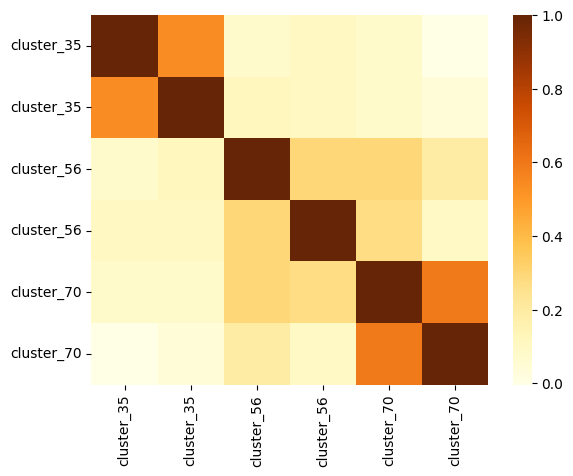

In [20]:
tmp = pd.concat([c_35, c_56, c_70])
tmp = tmp[[str(i) for i in range(0, 768)]].T
tmp.columns=["cluster_35","cluster_35", "cluster_56","cluster_56","cluster_70","cluster_70"]
sns.heatmap(tmp.corr(), cmap="YlOrBr");

In [30]:
emb_lst = [str(i) for i in range(0, 768)]
emb_lst.extend(["cluster"])
tmp_df = merged[merged["cluster"].isin([35, 56, 70])].loc[:, emb_lst]

In [28]:
import umap, joblib
filename = "./umap_reducer.sav"
loaded_reducer = joblib.load(filename)

In [37]:
reduction_result = loaded_reducer.fit_transform(tmp_df.loc[:, [str(i) for i in range(0, 768)]])

In [39]:
reduction_result.shape

(607, 10)

In [40]:
reduction_result = pd.DataFrame(reduction_result, columns=["dim"+str(i) for i in range(1, 11)])
tmp_df = pd.concat([tmp_df, reduction_result], axis=1)
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1205 entries, 26 to 606
Columns: 779 entries, 0 to dim10
dtypes: float32(10), float64(769)
memory usage: 7.1 MB


<Axes: xlabel='0', ylabel='1'>

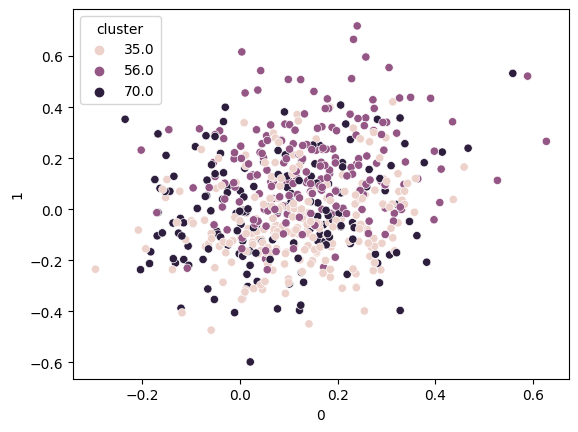

In [47]:
sns.scatterplot(x=tmp_df["0"], y=tmp_df["1"], hue=tmp_df["cluster"])

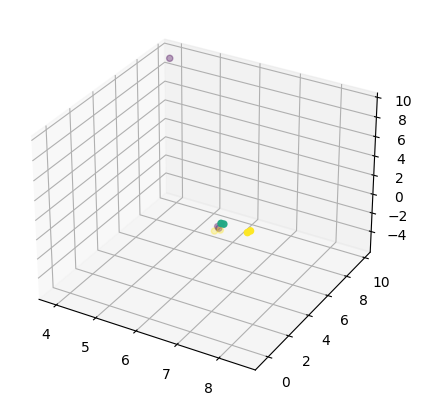

In [46]:
plt.figure(figsize=(6, 5))
axes = plt.axes(projection="3d")
axes.scatter3D(xs=tmp_df["dim4"], ys=tmp_df["dim2"], zs=tmp_df["dim1"], c=tmp_df["cluster"])
plt.show()

<Axes: xlabel='0', ylabel='1'>

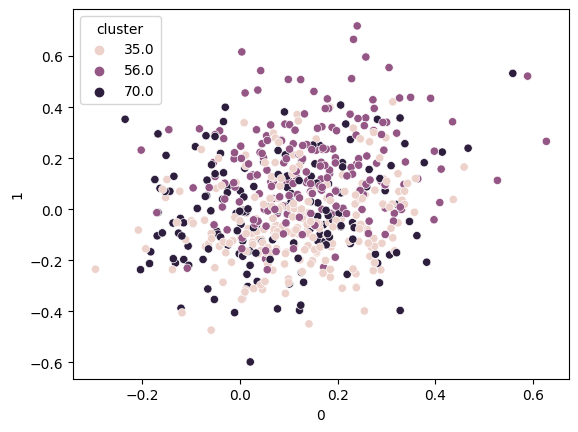